In [1]:
import pandas as pd
import csv
import re
from datetime import datetime
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
def parseElasticSearchDate(timestamp):
    return datetime.strptime(timestamp, '%b %d, %Y @ %H:%M:%S.%f')

In [3]:
def csvToList(filename, valueKey, timestamp_key="@timestamp"):
    csvList = []
    with open(filename, 'r') as data:  
        for line in csv.DictReader(data):
            timestamp = parseElasticSearchDate(line[timestamp_key])
            csvList.append((timestamp, line[valueKey]))
    return csvList

In [4]:
def closestDatetime(metricList, date):
    return float(min(metricList, key=lambda x: abs(x[0] - date))[1][:-1])

In [13]:
def getResultPath(experiment, sessionSize, approach, metric):
    return '%s/%s_Participants_Per_Session/%s/%s_%s_%s.csv' %  (experiment, sessionSize, approach, sessionSize, approach, metric)

In [17]:
def generateChart(dfs, ax, title, ylabel):
    df = reduce(lambda left,right: left.merge(right, how= "right" if len(right.index) > len(left.index) else "left"), dfs)
    df = df.drop(columns=['Users']) 
    ax_df = df.plot.line(title=title, ax = ax)
    ax_df.set_ylabel(ylabel)  
    ax_df.set_xlabel("Number of users")

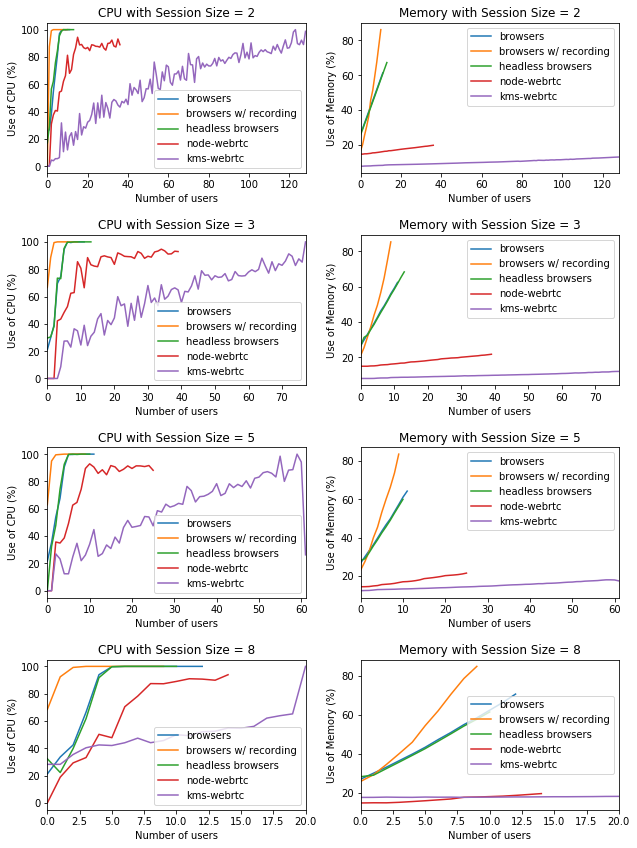

In [20]:
sessionSizes = ["2", "3", "5", "8"]
# Approach with more users should be the first
approaches = ["SeleniumWithoutRecording", "SeleniumWithRecording", "SeleniumHeadless", "NodeWebRTC", "KMS"]
approaches_map = {
    "KMS" : "kms-webrtc",
    "NodeWebRTC" : "node-webrtc", 
    "SeleniumWithRecording" : "browsers w/ recording",
    "SeleniumWithoutRecording" : "browsers",
    "SeleniumHeadless" : "headless browsers"
}

figure, axes = plt.subplots(4, 2)
figure.set_size_inches(9, 12)
row = 0

for sessionSize in sessionSizes:
    
    cpu_dfs = []
    mem_dfs = []
    
    for approach in approaches:
        cpu_path = getResultPath("Preliminar", sessionSize, approach, "CPU")
        mem_path = getResultPath("Preliminar", sessionSize, approach, "Mem")
        joined_path = getResultPath("Preliminar", sessionSize, approach, "Joined")
        cpuList = csvToList(cpu_path, 'system.cpu.total.norm.pct')
        memList = csvToList(mem_path, 'system.memory.used.pct')
        
        unorderJoinedList = []
        with open(joined_path, 'r') as data:
            
            orderedJoinedList = sorted(
                map(lambda l: parseElasticSearchDate(l["timestamp"]), csv.DictReader(data))
            )
        
        count = 0
        
        data = {
            "users": [],
            "cpu": [],
            "mem": []
        }
        
        for userJoinedTimeStamp in orderedJoinedList:
            count = count + 1
            closestCpuMetric = closestDatetime(cpuList, userJoinedTimeStamp)
            closestMemMetric = closestDatetime(cpuList, userJoinedTimeStamp)
            data["users"].append(count)
            data["cpu"].append(closestCpuMetric)
            data["mem"].append(closestMemMetric)
        
        cpu_data = {}
        cpu_data["Users"] = data["users"]
        cpu_data[approaches_map[approach]] = data["cpu"]
        cpu_dfs.append(pd.DataFrame(cpu_data))
        
        mem_data = {}
        mem_data["Users"] = data["users"]
        mem_data[approaches_map[approach]] = data["mem"]
        mem_dfs.append(pd.DataFrame(mem_data))
    
    # Generate CPU Chart    
    generateChart(cpu_dfs, axes[row, 0], "CPU with Session Size = %s"%sessionSize, "Use of CPU (%)")
    
    # Generate Mem
    generateChart(mem_dfs, axes[row, 1], "Memory with Session Size = %s"%sessionSize, "Use of Memory (%)")
    
    row = row + 1

plt.rcParams.update({'font.size': 10 })
figure.tight_layout(pad=1.5)
figure.savefig("Preliminar/images/AllChartsInOne.pdf")

In [21]:
table = []

max_sessions_map = {}
max_users_map = {}

for sessionSize in experiments:    
    
    for approach in approaches:
        
        joined_path = 'Preliminar/%s_Participants_Per_Session/%s/%s_%s_Joined.csv' %  (sessionSize, approach, sessionSize, approach)
        with open(joined_path, 'r') as data:  
            lines = list(csv.DictReader(data))
            # Fill table
            numUsers = len(lines)
            numSessions = int(numUsers/int(sessionSize))
            table.append([sessionSize, approaches_map[approach], numSessions, "%d (%d)"%(numSessions*int(sessionSize),numUsers)])
            approach_graph_name = approaches_map[approach]
            
            if approach_graph_name not in max_sessions_map:
                max_sessions_map[approach_graph_name] = []
                
            if approach_graph_name not in max_users_map:
                max_users_map[approach_graph_name] = []
            
            max_sessions_map[approach_graph_name].append(numSessions)
            max_users_map[approach_graph_name].append(numUsers)
            
df = pd.DataFrame(table)
df.columns =['Session size', 'Testing strategies', 'Max complete Sessions', 'Max users']
df = df.set_index('Session size')
df.to_csv("Preliminar/results/preliminary_results.csv")
df

,Testing strategies,Max complete Sessions,Max users
Session size,,,
2,browsers,6,12 (12)
2,browsers w/ recording,5,10 (11)
2,headless browsers,7,14 (14)
2,node-webrtc,18,36 (37)
2,kms-webrtc,64,128 (129)
3,browsers,4,12 (12)
3,browsers w/ recording,3,9 (10)
3,headless browsers,4,12 (14)
3,node-webrtc,13,39 (40)


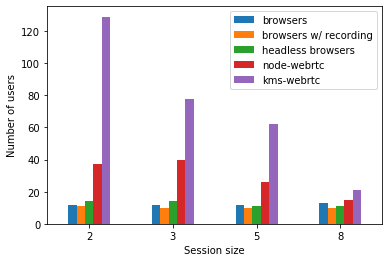

In [22]:
df = pd.DataFrame(max_users_map, index=sessionSizes)
ax = df.plot.bar(rot=0)
ax.set_ylabel("Number of users")
ax.set_xlabel("Session size")
ax.figure.savefig("Preliminar/images/UserComparation.pdf")

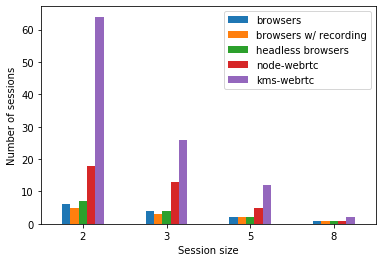

In [23]:
df = pd.DataFrame(max_sessions_map, index=sessionSizes)
ax = df.plot.bar(rot=0)
ax.set_ylabel("Number of sessions")
ax.set_xlabel("Session size")
ax.figure.savefig("Preliminar/images/SessionComparation.pdf")